In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, Concatenate, BatchNormalization, Dropout, Activation, LeakyReLU
from keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
import cv2
import kagglehub
import random
import numpy as np
import glob
from PIL import Image

print(tf.__version__)
tf.config.list_physical_devices()

2.19.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# mdn_lymph_nodes_path = kagglehub.dataset_download('luckyx100/mdn-lymph-nodes')
# mdn_lymph_nodes_path

In [4]:
# IMGS_DIR = f"{mdn_lymph_nodes_path}/images/"
# MASKS_DIR = f"{mdn_lymph_nodes_path}/masks/"

IMGS_DIR = r'/mnt/d/Updated_Dataset/Images'
MASKS_DIR = r'/mnt/d/Updated_Dataset/Masks'
print(os.listdir(IMGS_DIR))
print(f"Total Imgs: {len(os.listdir(IMGS_DIR))} | Total Masks: {len(os.listdir(MASKS_DIR))}")

['P1', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P2', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P3', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P4', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P5', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P6', 'P60', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P7', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P8', 'P80', 'P81', 'P82', 'P83', 'P84', 'P85', 'P86', 'P9']
Total Imgs: 86 | Total Masks: 86


In [5]:
from data_aug import DataGenerator

In [6]:
dg = DataGenerator(IMGS_DIR, MASKS_DIR, IMAGE_SIZE=(256, 256), test_size=0.1)

In [7]:
X_train, Y_train, X_val, Y_val = dg.get_local_data()

In [8]:
X_train.shape

(462, 256, 256, 1)

In [10]:
sample_img_path = f"{IMGS_DIR}/P1/"
os.listdir(sample_img_path)

['._adb-p1-img-366.png',
 'adb-p1-img-366.png',
 'adb-p1-img-370.png',
 'adb-p1-img-418.png']

In [5]:
sample_img_path = f"{IMGS_DIR}/P1/adb-p1-img-418.png"
sample_mask_path = f"{MASKS_DIR}/P1/ABD_LYMPH_Mask_418.png"

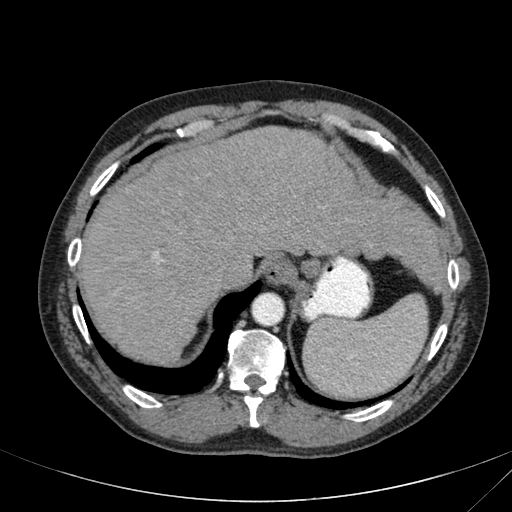

In [6]:
sample_img = Image.open(sample_img_path)
sample_img

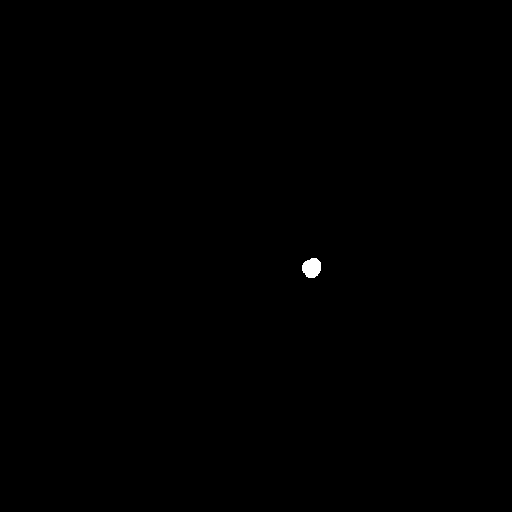

In [7]:
sample_mask = Image.open(sample_mask_path)
sample_mask

In [8]:
print(f"IMG: {sample_img.height} x {sample_img.width} x {len(sample_img.getbands())}")
print(f"MASK: {sample_mask.height} x {sample_mask.width} x {len(sample_mask.getbands())}")

IMG: 512 x 512 x 1
MASK: 512 x 512 x 1


In [17]:
IMAGE_SIZE = (256, 256)  # Match U-Net input size

'''

def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load CT in grayscale
    img = cv2.resize(img, IMAGE_SIZE)  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
    return np.expand_dims(img, axis=-1)  # Keep (H, W, 1) shape

def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask
    mask = cv2.resize(mask, IMAGE_SIZE)  # Resize
    mask = (mask > 127).astype(np.uint8)  # Binarize (0 or 1)
    return np.expand_dims(mask, axis=-1)


# Function to get all image-mask pairs recursively
def get_image_mask_pairs(image_dir, mask_dir):
    image_mask_pairs = []

    # Iterate over patient folders
    for patient_id in sorted(os.listdir(image_dir)):  
        patient_image_path = os.path.join(image_dir, patient_id)
        patient_mask_path = os.path.join(mask_dir, patient_id)

        print(patient_image_path)

        if not os.path.isdir(patient_image_path) or not os.path.isdir(patient_mask_path):
            continue  # Skip if not a directory

        # Get all images and masks in the patient folder
        image_files = sorted(os.listdir(patient_image_path))
        mask_files = sorted(os.listdir(patient_mask_path))

        print(image_files)

        # Ensure images and masks are paired correctly
        for img_file, mask_file in zip(image_files, mask_files):
            img_path = os.path.join(patient_image_path, img_file)
            mask_path = os.path.join(patient_mask_path, mask_file)

            
            if img_path == "mnt/d/Updated_Dataset/Images/P1/._adb-p1-img-366.png":
                continue

            print(img_path)
            if os.path.exists(mask_path):  # Ensure mask exists
                image_mask_pairs.append((img_path, mask_path))

    return image_mask_pairs
    
'''

# IMAGE_SIZE = (256, 256)  # Match U-Net input size

def load_image(image_path):
    # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load CT in grayscale
    # img = cv2.resize(img, IMAGE_SIZE)  # Resize
    # img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
    # return np.expand_dims(img, axis=-1)  # Keep (H, W, 1) shape
    if not os.path.exists(image_path):
        print(f"Error: Image file not found -> {image_path}")
        return None
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Failed to load image -> {image_path}")
        return None

    img = cv2.resize(img, IMAGE_SIZE)  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize
    return np.expand_dims(img, axis=-1)


def load_mask(mask_path):
    # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask
    # mask = cv2.resize(mask, IMAGE_SIZE)  # Resize
    # mask = (mask > 127).astype(np.uint8)  # Binarize (0 or 1)
    # return np.expand_dims(mask, axis=-1)
    if not os.path.exists(mask_path):
        print(f"Error: Mask file not found -> {mask_path}")
        return None

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Error: Failed to load mask -> {mask_path}")
        return None

    mask = cv2.resize(mask, IMAGE_SIZE)  # Resize
    mask = (mask > 127).astype(np.uint8)  # Binarize
    return np.expand_dims(mask, axis=-1)


# Function to get all image-mask pairs recursively
def get_image_mask_pairs(image_dir, mask_dir):
    image_mask_pairs = []

    # Iterate over patient folders
    for patient_id in sorted(os.listdir(image_dir)):  

        
        patient_image_path = os.path.join(image_dir, patient_id)
        patient_mask_path = os.path.join(mask_dir, patient_id)

        if not os.path.isdir(patient_image_path):
            continue
            
        print(patient_image_path)

        if not os.path.isdir(patient_image_path) or not os.path.isdir(patient_mask_path):
            continue  # Skip if not a directory

        # Get all images and masks in the patient folder
        image_files = sorted(os.listdir(patient_image_path))
        mask_files = sorted(os.listdir(patient_mask_path))

        print(image_files)

        # Ensure images and masks are paired correctly
        for img_file, mask_file in zip(image_files, mask_files):
            
            img_path = os.path.join(patient_image_path, img_file)
            mask_path = os.path.join(patient_mask_path, mask_file)

            if img_path.split("/")[-1][0] == ".":
                continue
            
            if img_path == "/kaggle/input/mdn-lymph-nodes/Images/Images/P1/._adb-p1-img-366.png":
                print(img_path)
                continue

            if os.path.exists(mask_path):  # Ensure mask exists
                image_mask_pairs.append((img_path, mask_path))

    return image_mask_pairs

In [18]:
image_mask_list = get_image_mask_pairs(IMGS_DIR, MASKS_DIR)

/mnt/d/Updated_Dataset/Images/P1
['._adb-p1-img-366.png', 'adb-p1-img-366.png', 'adb-p1-img-370.png', 'adb-p1-img-418.png']
/mnt/d/Updated_Dataset/Images/P10
['ABD_LYMPH_IMG_309.png', 'ABD_LYMPH_IMG_315.png', 'ABD_LYMPH_IMG_343.png', 'ABD_LYMPH_IMG_355.png']
/mnt/d/Updated_Dataset/Images/P11
['ABD_LYMPH_IMG_149.png', 'ABD_LYMPH_IMG_267.png', 'ABD_LYMPH_IMG_310.png', 'ABD_LYMPH_IMG_321.png', 'ABD_LYMPH_IMG_409.png', 'ABD_LYMPH_IMG_461.png']
/mnt/d/Updated_Dataset/Images/P12
['ABD_LYMPH_IMG_371.png']
/mnt/d/Updated_Dataset/Images/P13
['ABD_IMG_P13_171.png', 'ABD_IMG_P13_238.png', 'ABD_IMG_P13_245.png', 'ABD_IMG_P13_256.png', 'ABD_IMG_P13_265.png', 'ABD_IMG_P13_278.png', 'ABD_IMG_P13_285.png']
/mnt/d/Updated_Dataset/Images/P14
['ABD_LYMPH_IMG_021.png', 'ABD_LYMPH_IMG_031.png', 'ABD_LYMPH_IMG_042.png', 'ABD_LYMPH_IMG_084.png', 'ABD_LYMPH_IMG_087.png', 'ABD_LYMPH_IMG_096.png', 'ABD_LYMPH_IMG_097.png', 'ABD_LYMPH_IMG_110.png', 'ABD_LYMPH_IMG_115.png', 'ABD_LYMPH_IMG_162.png', 'ABD_LYMPH_IMG_

In [19]:
# image_mask_list
len(image_mask_list)

514

In [20]:
image_mask_list[4]

('/mnt/d/Updated_Dataset/Images/P10/ABD_LYMPH_IMG_315.png',
 '/mnt/d/Updated_Dataset/Masks/P10/ABD_LYMPH_Mask_315.png')

In [21]:
# Load images & masks
images = np.array([load_image(img_path) for img_path, _ in image_mask_list])
masks = np.array([load_mask(mask_path) for _, mask_path in image_mask_list])

In [22]:
masks = masks.astype("float32")
images.dtype, masks.dtype

(dtype('float32'), dtype('float32'))

In [23]:
images.shape, masks.shape

((514, 256, 256, 1), (514, 256, 256, 1))

In [24]:
# Train-Test Split
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.1, random_state=42)
train_path, val_path = train_test_split(image_mask_list, test_size=0.1, random_state=42)

In [25]:
len(train_path), len(X_train)

(462, 462)

In [26]:
len(val_path), len(X_val)

(52, 52)

In [27]:
train_path[3]

('/mnt/d/Updated_Dataset/Images/P2/ABD_LYMPH_IMG_272.png',
 '/mnt/d/Updated_Dataset/Masks/P2/ABD_LYMPH_Mask_272.png')

In [28]:
print(X_train.shape, Y_train.shape)
X_train[15, 156:200, 156:200]

(462, 256, 256, 1) (462, 256, 256, 1)


array([[[0.15686275],
        [0.14509805],
        [0.22352941],
        ...,
        [0.7607843 ],
        [0.7529412 ],
        [0.7294118 ]],

       [[0.16862746],
        [0.17254902],
        [0.22352941],
        ...,
        [0.7254902 ],
        [0.7411765 ],
        [0.7647059 ]],

       [[0.10588235],
        [0.16862746],
        [0.14509805],
        ...,
        [0.7254902 ],
        [0.7176471 ],
        [0.7490196 ]],

       ...,

       [[0.18431373],
        [0.23921569],
        [0.35686275],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.43529412],
        [0.4117647 ],
        [0.37254903],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.09803922],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]], dtype=float32)

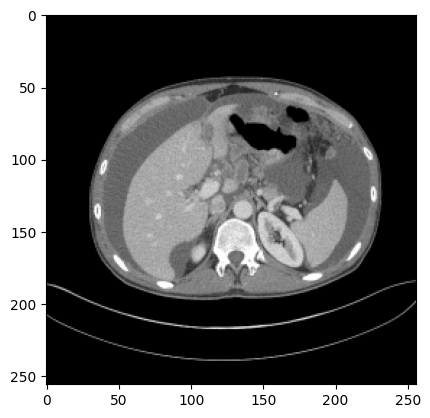

In [29]:
plt.imshow(X_train[0], cmap="gray")

In [30]:
print(X_val.shape, Y_val.shape)
X_val[10, :-50, :-10]

(52, 256, 256, 1) (52, 256, 256, 1)


array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.25490198]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.24705882],
        [0.5803922 ],
        [0.3137255 ]]], dtype=float32)

In [31]:
# Printing the max pixel value in X_train, X_val
X_train[0].max(), X_val[0].max(), X_train[0].min(), X_val[0].min()

(np.float32(1.0), np.float32(1.0), np.float32(0.0), np.float32(0.0))

In [32]:
import random

def display_sample(X, Y, index, path):
    plt.figure(figsize=(10, 5))
    img_name = path[index][0].split('/')[-1]
    mask_name = path[index][1].split('/')[-1]

    plt.subplot(1, 2, 1)
    plt.imshow(X[index].squeeze(), cmap='gray')
    plt.title(f"{img_name}")

    plt.subplot(1, 2, 2)
    plt.imshow(Y[index].squeeze(), cmap='gray')
    plt.title(f"{mask_name}")

    plt.show()

    # print(f"Image Path: {img_name}")
    # print(f"Mask Path: {mask_name}")

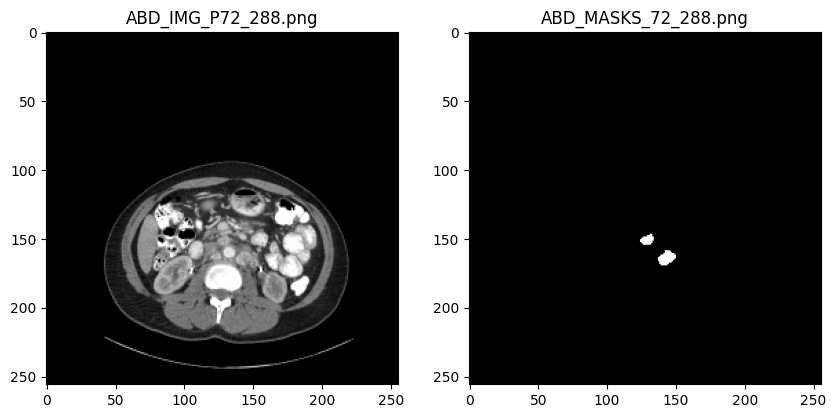

In [41]:
display_sample(X_train, Y_train, random.randint(0, len(X_train)), train_path)

In [41]:
import numpy as np
import scipy.ndimage

def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)
    
    shape = image.shape
    dx = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)
    
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))
    
    distored_image = scipy.ndimage.map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

def augment_data(X, Y, num_augmentations=1, alpha=34, sigma=4):
    augmented_X = []
    augmented_Y = []
    
    for i in range(len(X)):
        for _ in range(num_augmentations):
            X_deformed = elastic_transform(X[i], alpha, sigma)
            Y_deformed = elastic_transform(Y[i], alpha, sigma)
            augmented_X.append(X_deformed)
            augmented_Y.append(Y_deformed)
    
    return np.array(augmented_X), np.array(augmented_Y)

# Augment the training and test datasets
augmented_X_train, augmented_Y_train = augment_data(X_train, Y_train, num_augmentations=5)
augmented_X_val, augmented_Y_val = augment_data(X_val, Y_val, num_augmentations=5)

# Combine the original and augmented datasets
X_train_combined = np.concatenate((X_train, augmented_X_train), axis=0)
Y_train_combined = np.concatenate((Y_train, augmented_Y_train), axis=0)
X_val_combined = np.concatenate((X_val, augmented_X_val), axis=0)
Y_val_combined = np.concatenate((Y_val, augmented_Y_val), axis=0)

# Print the shapes of the combined datasets
print(f"Original X_train shape: {X_train.shape}, Augmented X_train shape: {X_train_combined.shape}")
print(f"Original Y_train shape: {Y_train.shape}, Augmented Y_train shape: {Y_train_combined.shape}")
print(f"Original X_val shape: {X_val.shape}, Augmented X_val shape: {X_val_combined.shape}")
print(f"Original Y_val shape: {Y_val.shape}, Augmented Y_val shape: {Y_val_combined.shape}")

Original X_train shape: (305, 256, 256, 1), Augmented X_train shape: (1830, 256, 256, 1)
Original Y_train shape: (305, 256, 256, 1), Augmented Y_train shape: (1830, 256, 256, 1)
Original X_val shape: (34, 256, 256, 1), Augmented X_val shape: (204, 256, 256, 1)
Original Y_val shape: (34, 256, 256, 1), Augmented Y_val shape: (204, 256, 256, 1)


In [42]:
my_kernel = tf.keras.initializers.HeNormal(seed=42)

In [43]:
def conv_block(input_tensor, filters, dropout=False, use_leaky=False):
    x = Conv2D(filters, (3, 3), padding="same", activation="relu", kernel_initializer=my_kernel, kernel_regularizer=l2(0.001))(input_tensor)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x) if use_leaky else Activation("relu")(x)

    x = Conv2D(filters, (3, 3), padding="same", activation="relu", kernel_initializer=my_kernel, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x) if use_leaky else Activation("relu")(x)

    if dropout:
        x = Dropout(0.3)(x)
    return x

def unet_model(input_size=(256, 256, 1), num_classes=1):
    inputs = Input(input_size)

    # Encoder
    c1 = conv_block(inputs, 32, dropout=True)
    m1 = MaxPool2D((2, 2))(c1)

    c2 = conv_block(m1, 64, dropout=True)
    m2 = MaxPool2D((2, 2))(c2)

    c3 = conv_block(m2, 128, dropout=True)
    m3 = MaxPool2D((2, 2))(c3)

    c4 = conv_block(m3, 256, dropout=True)
    m4 = MaxPool2D((2, 2))(c4)

    # Bottleneck
    center = conv_block(m4, 512, dropout=True)

    # Decoder
    u4 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same", kernel_initializer=my_kernel, kernel_regularizer=l2(0.001))(center)
    sc4 = Concatenate()([u4, c4])
    c4_ep = conv_block(sc4, 256, dropout=True)

    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same", kernel_initializer=my_kernel, kernel_regularizer=l2(0.001))(c4_ep)
    sc3 = Concatenate()([u3, c3])
    c3_ep = conv_block(sc3, 128, dropout=True)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same", kernel_initializer=my_kernel, kernel_regularizer=l2(0.001))(c3_ep)
    sc2 = Concatenate()([u2, c2])
    c2_ep = conv_block(sc2, 64, dropout=True)

    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same", kernel_initializer=my_kernel, kernel_regularizer=l2(0.001))(c2_ep)
    sc1 = Concatenate()([u1, c1])
    c1_ep = conv_block(sc1, 32, dropout=True)

    # Output Layer
    activation = "sigmoid" if num_classes == 1 else "softmax"
    outputs = Conv2D(num_classes, (1, 1), activation=activation, kernel_initializer=my_kernel, kernel_regularizer=l2(0.001))(c1_ep)

    return Model(inputs, outputs)


In [44]:
model = unet_model(input_size=(256, 256, 1), num_classes=1)

In [ ]:
model.summary()

In [46]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred, alpha=0.3):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    # return bce + dice_loss(y_true, y_pred)
    return alpha * bce + (1 - alpha) * dice

In [47]:
model.compile(optimizer="adamw", loss=combined_loss, metrics=[dice_coefficient])

In [48]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train_combined, Y_train_combined,
    validation_data=(X_val_combined, Y_val_combined),
    shuffle=True,
    epochs=100,
    batch_size=16,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - dice_coefficient: 0.0057 - loss: 4.3025

2025-03-15 09:44:45.655017: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_13', 60 bytes spill stores, 60 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_12', 56 bytes spill stores, 56 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 60 bytes spill stores, 60 bytes spill loads



115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 437ms/step - dice_coefficient: 0.0057 - loss: 4.2704 - val_dice_coefficient: 0.0058 - val_loss: 1.0869
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - dice_coefficient: 0.0326 - loss: 0.8497 - val_dice_coefficient: 0.0042 - val_loss: 0.7923
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - dice_coefficient: 0.1071 - loss: 0.7307 - val_dice_coefficient: 4.6362e-05 - val_loss: 0.8394
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 187ms/step - dice_coefficient: 0.2083 - loss: 0.6884 - val_dice_coefficient: 1.0149e-04 - val_loss: 0.8459
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - dice_coefficient: 0.2953 - loss: 0.6425 - val_dice_coefficient: 5.0043e-05 - val_loss: 0.8508
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - dice_coefficient: 0.3667 - loss: 0.5888 - val_dice_coefficient: 1.4076e-04 - val_loss: 0.8628
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - dice_coefficient: 0.3897 - loss: 0.5853 - val_dice

Text(0, 0.5, 'Dice Coefficient')

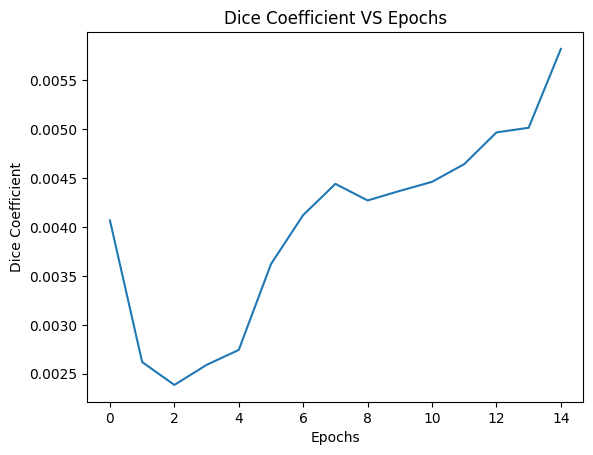

In [82]:
plt.plot(history.history['dice_coefficient'])
plt.title('Dice Coefficient VS Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')

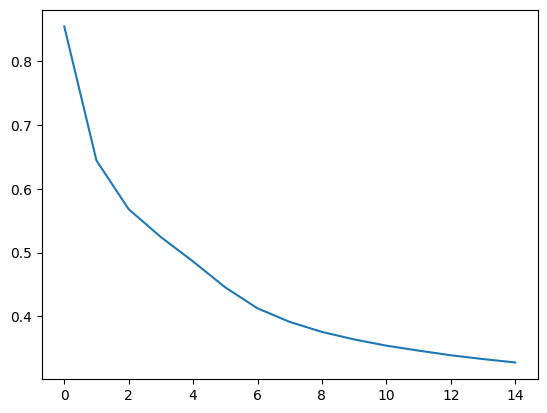

In [83]:
plt.plot(history.history['loss'])

In [67]:
loss, dc = model.evaluate(X_val, Y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - dice_coefficient: 0.0411 - loss: 0.2556


In [68]:
f"Loss: {(loss*100):.2f}% & Dice Coefficient: {(dc*100):.2f}%"

'Loss: 25.55% & Dice Coefficient: 4.64%'

In [44]:
preds = model.predict(X_val)
preds.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 896ms/step


(34, 256, 256, 1)

Text(0.5, 1.0, 'Truth')

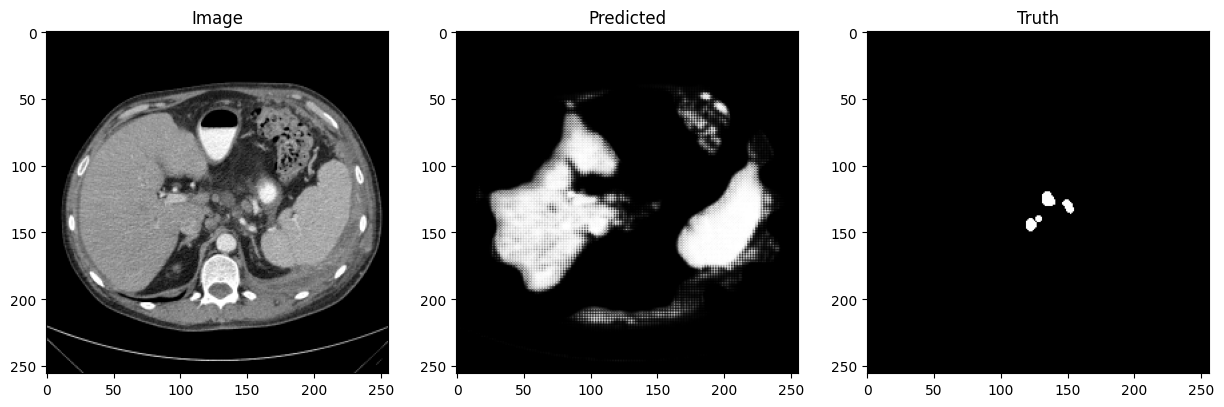

In [54]:
x = random.randint(0, len(X_val) - 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_val[x], cmap="gray")
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(preds[x], cmap="gray")
plt.title("Predicted")

plt.subplot(1, 3, 3)
plt.imshow(Y_val[x], cmap="gray")
plt.title("Truth")

In [55]:
train_preds = model.predict(X_train)
train_preds.shape

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 729ms/step


(305, 256, 256, 1)

Text(0.5, 1.0, 'Truth')

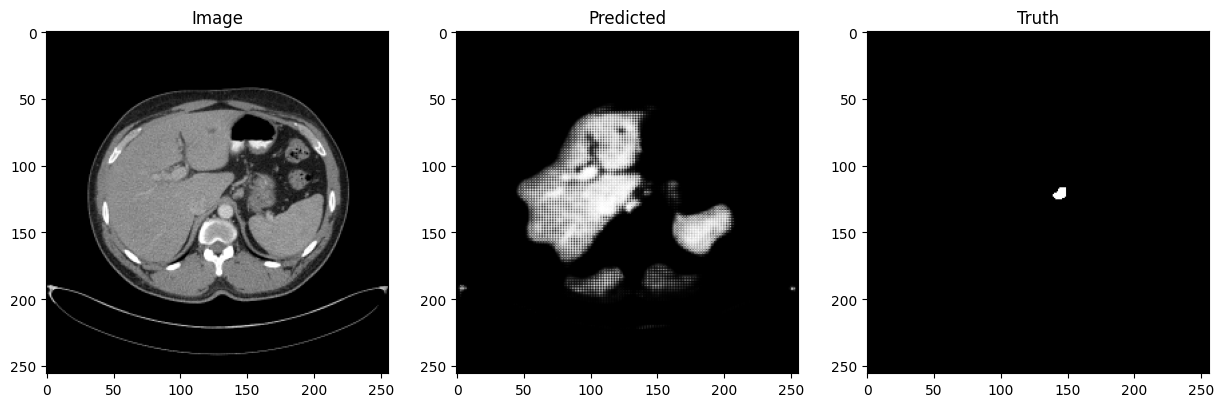

In [60]:
x = random.randint(0, len(X_train) - 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_train[x], cmap="gray")
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(train_preds[x], cmap="gray")
plt.title(f"Predicted")

plt.subplot(1, 3, 3)
plt.imshow(Y_train[x], cmap="gray")
plt.title("Truth")